In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import keras
from dataset_generator import TimeWindowDatasetGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder

In [5]:
from dataset_generator import TimeWindowDatasetGenerator
twg = TimeWindowDatasetGenerator()
df = twg.get_labelled_timewindow_dataframe(
    exclude_after_notification=True, 
    label_feature="affect", 
    time_window=10)

In [6]:
session_df = pd.read_csv('task/SessionData-all.csv')
session_df.head()

id  duration watchId    age  gender  fairNumber
0   1   8021351    0Q3V  18-25  female           1
1   2   3752526    0Q3V  26-30    male           1
2   3   3989497    0QED  18-25    male           1
3   4   4979198    0QED  18-25    male           1
4   5   4836199    0QVM  18-25    male           1

In [11]:
non_feat_columns = ["ppgValue", "notification", "engagement", "hrStatus","ibiStatus", "affect", "context","duration","id"]
df.loc[df['hrStatus'] != 1, 'hr'] = np.nan #| 1 | Successful heart rate measurement. |(the rest is trash)
df.loc[df['ibiStatus'] == 1, 'hrIbi'] = np.nan # | Status flag for Ibi -> 1: bad; 0: good. |
df = pd.merge(left=df, right=session_df, left_on="sessionId", right_on="id")
df = df.drop(columns=non_feat_columns)
df["sessionId_key"]= df["sessionId"]
df["label_id_key"]= df["label_id"]
df = df.groupby(["sessionId_key", "label_id_key"]).ffill().bfill() #fill missing data (backfill as the last step to get the first few rows)
df.head()

sessionId  timestamp       x       y       z    hr   hrIbi  label_id  \
0          1     481283   978.0  1674.0  3632.0  99.0  1003.0         1   
1          1     481323   943.0  1717.0  3660.0  99.0  1003.0         1   
2          1     481363  1018.0  1610.0  3818.0  99.0  1003.0         1   
3          1     481403   898.0  1538.0  3733.0  99.0  1003.0         1   
4          1     481444  1028.0  1579.0  3852.0  99.0  1003.0         1   

     label watchId    age  gender  fairNumber  
0  WALKING    0Q3V  18-25  female           1  
1  WALKING    0Q3V  18-25  female           1  
2  WALKING    0Q3V  18-25  female           1  
3  WALKING    0Q3V  18-25  female           1  
4  WALKING    0Q3V  18-25  female           1

In [9]:
df

sessionId  timestamp       x       y       z   ppgValue  hr  hrIbi  \
12451            1     481283   978.0  1674.0  3632.0  2119260.0 NaN    NaN   
12452            1     481323   943.0  1717.0  3660.0  2119618.0 NaN    NaN   
12453            1     481363  1018.0  1610.0  3818.0  2119989.0 NaN    NaN   
12454            1     481403   898.0  1538.0  3733.0  2120342.0 NaN    NaN   
12455            1     481444  1028.0  1579.0  3852.0  2120722.0 NaN    NaN   
...            ...        ...     ...     ...     ...        ...  ..    ...   
8101256         58    6163376 -3730.0 -1465.0   396.0  2073936.0 NaN    NaN   
8101257         58    6163417 -3747.0 -1467.0   352.0  2074142.0 NaN    NaN   
8101258         58    6163458 -3763.0 -1416.0   340.0  2074560.0 NaN    NaN   
8101259         58    6163499 -3785.0 -1438.0   334.0  2074767.0 NaN    NaN   
8101260         58    6163589     NaN     NaN     NaN        NaN NaN    NaN   

         hrStatus  ibiStatus  notification  engagement affect context  \
12451         NaN        NaN           NaN         NaN    NaN     NaN   
12452         NaN        NaN           NaN         NaN    NaN     NaN   
12453         NaN        NaN           NaN         NaN    NaN     NaN   
12454         NaN        NaN           NaN         NaN    NaN     NaN   
12455         NaN        NaN           NaN         NaN    NaN     NaN   
...           ...        ...           ...         ...    ...     ...   
8101256       NaN        NaN           NaN         NaN    NaN     NaN   
8101257       NaN        NaN           NaN         NaN    NaN     NaN   
8101258       NaN        NaN           NaN         NaN    NaN     NaN   
8101259       NaN        NaN           NaN         NaN    NaN     NaN   
8101260       NaN        NaN           1.0         NaN    NaN     NaN   

         label_id    label  
12451           1  RELAXED  
12452           1  RELAXED  
12453           1  RELAXED  
12454           1  RELAXED  
12455           1  RELAXED  
...           ...      ...  
8101256       240    HAPPY  
8101257       240    HAPPY  
8101258       240    HAPPY  
8101259       240    HAPPY  
8101260       240    HAPPY  

[62481 rows x 16 columns]

In [12]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [13]:
def normalizer(column):
    result = (column - np.mean(column)) / np.std(column)
    return result

label_id
1      AxesSubplot(0.125,0.11;0.775x0.77)
2      AxesSubplot(0.125,0.11;0.775x0.77)
3      AxesSubplot(0.125,0.11;0.775x0.77)
7      AxesSubplot(0.125,0.11;0.775x0.77)
8      AxesSubplot(0.125,0.11;0.775x0.77)
                      ...                
213    AxesSubplot(0.125,0.11;0.775x0.77)
219    AxesSubplot(0.125,0.11;0.775x0.77)
222    AxesSubplot(0.125,0.11;0.775x0.77)
227    AxesSubplot(0.125,0.11;0.775x0.77)
231    AxesSubplot(0.125,0.11;0.775x0.77)
Length: 112, dtype: object

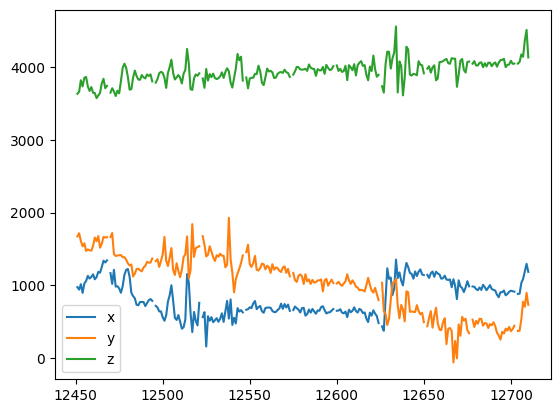

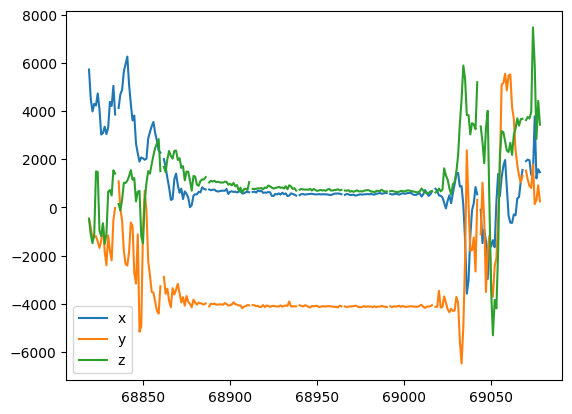

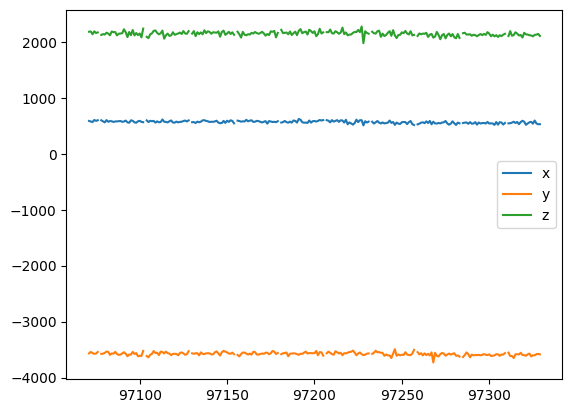

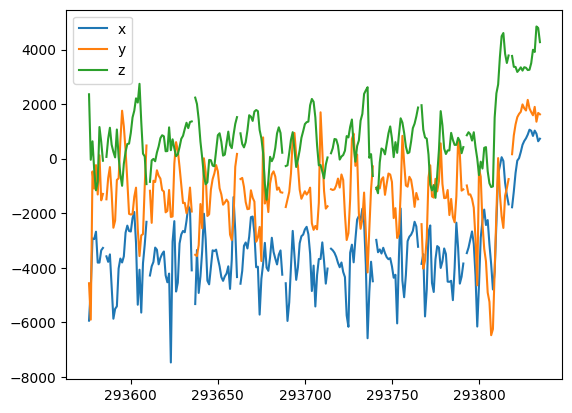

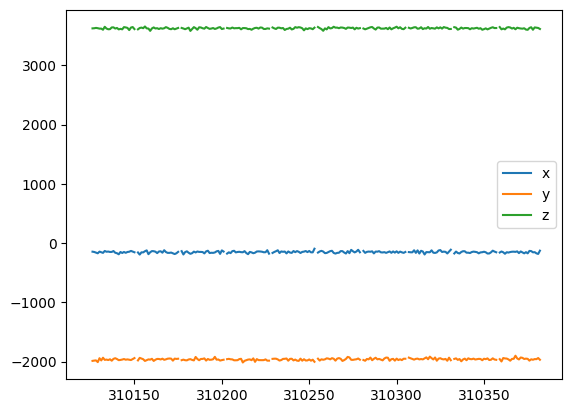

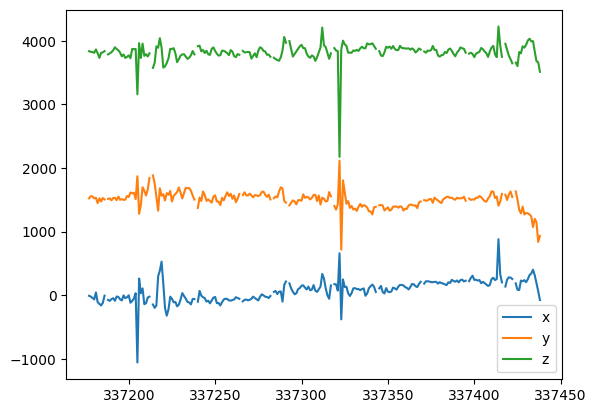

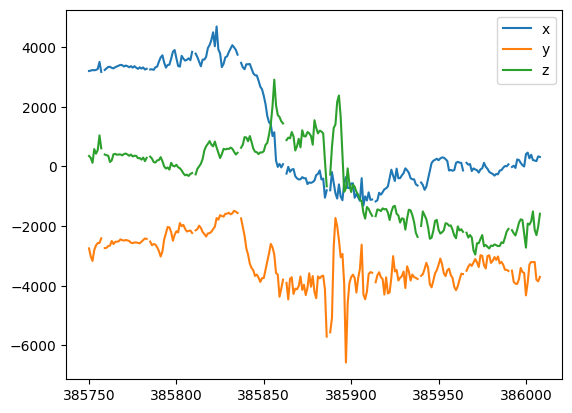

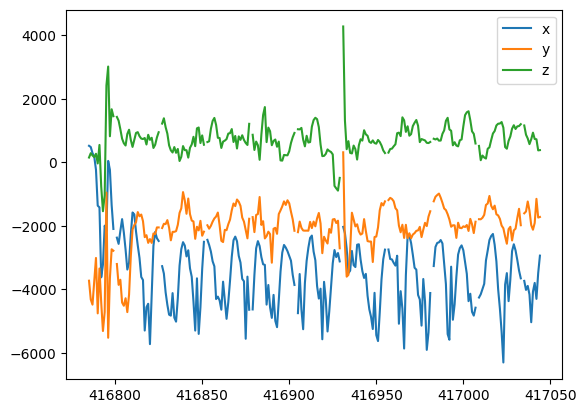

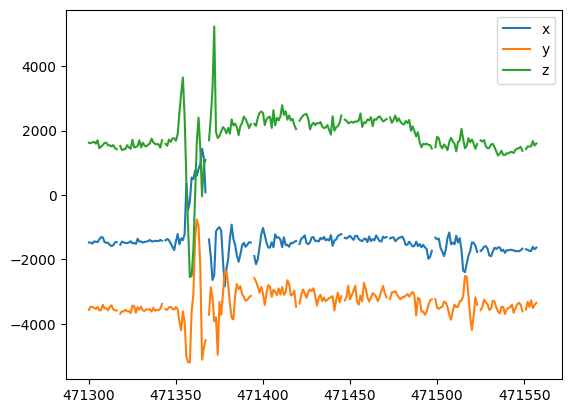

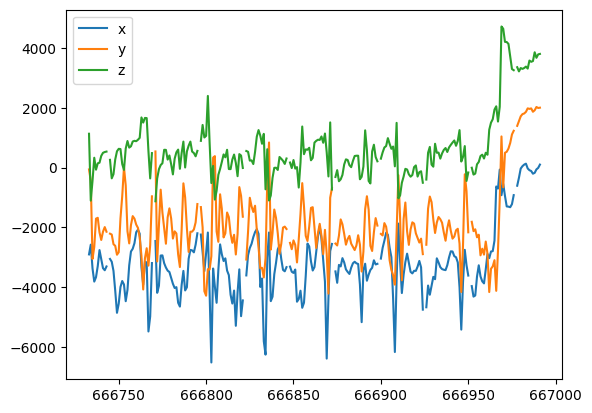

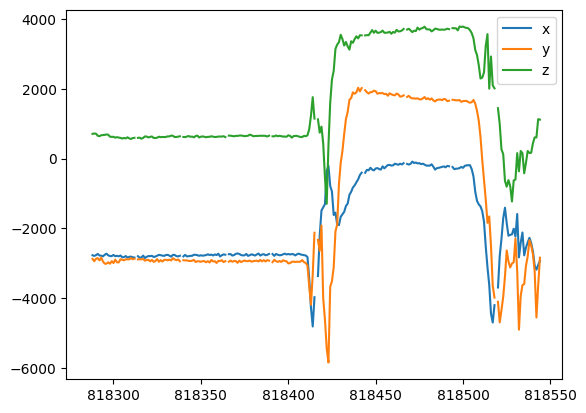

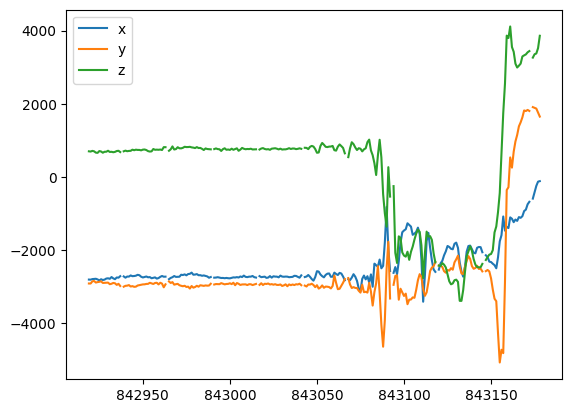

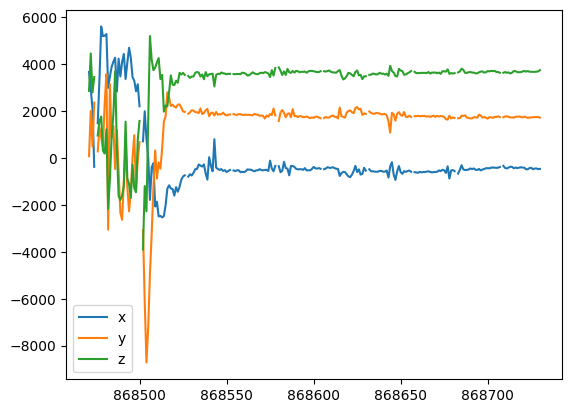

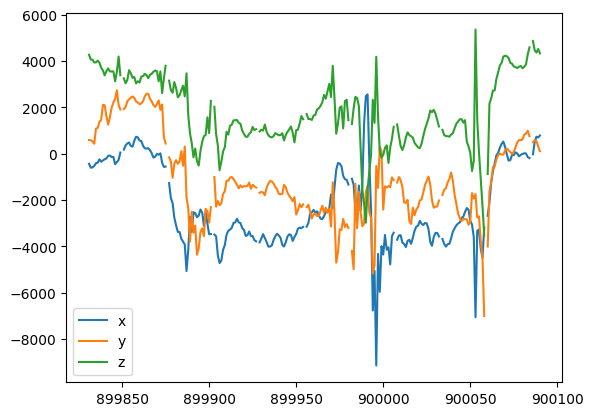

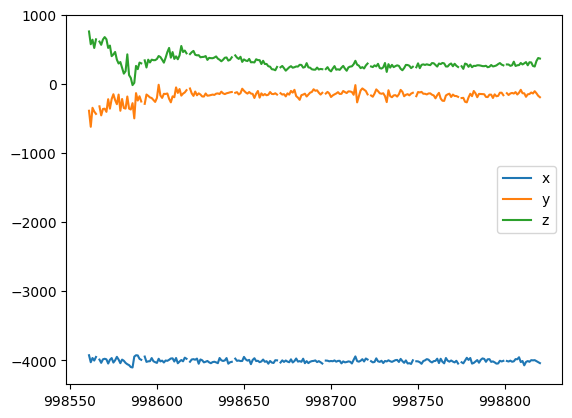

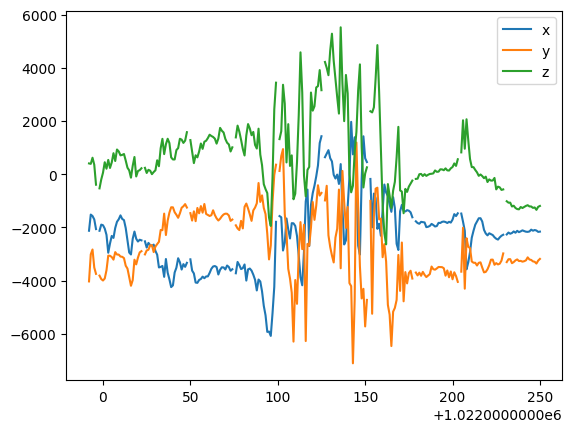

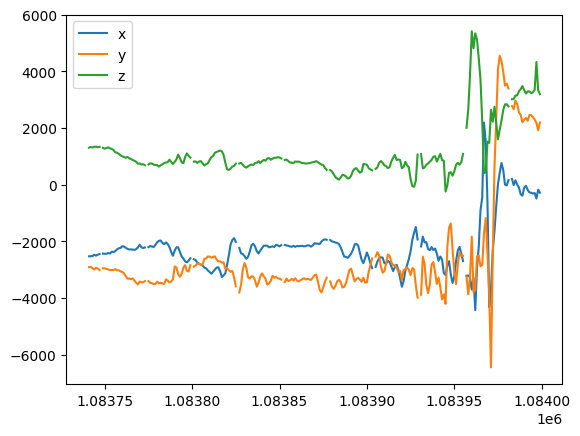

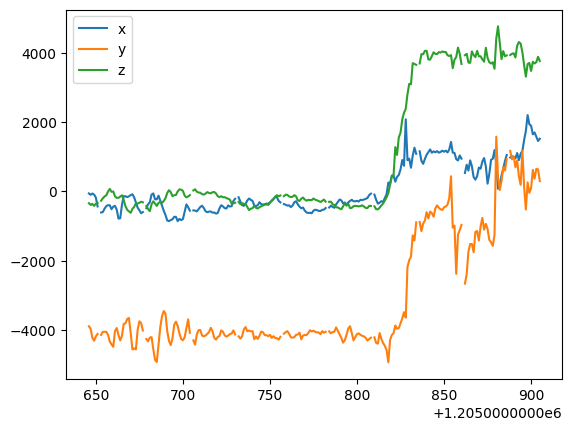

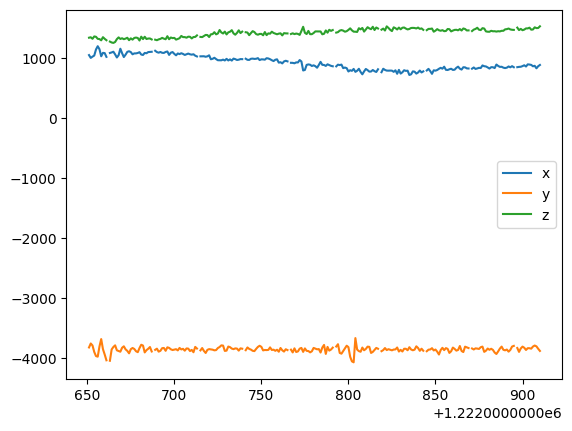

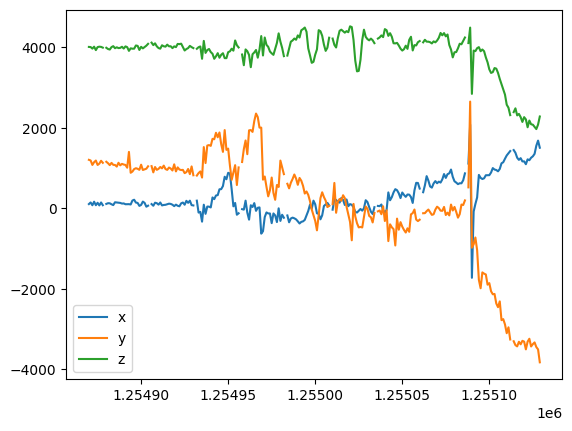

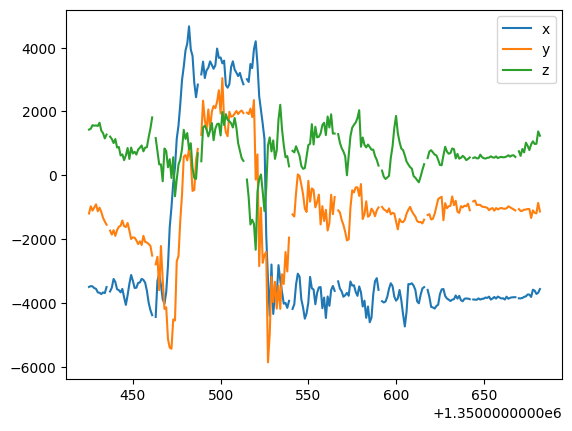

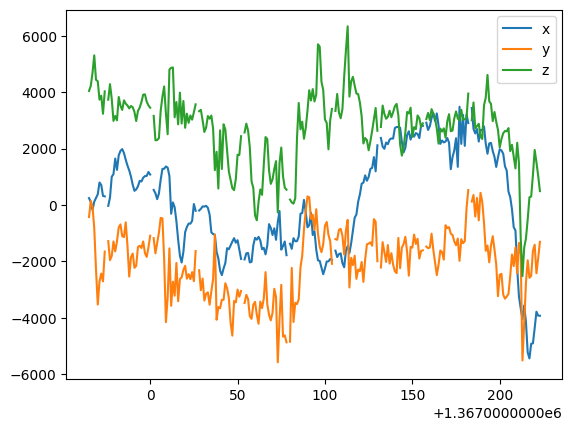

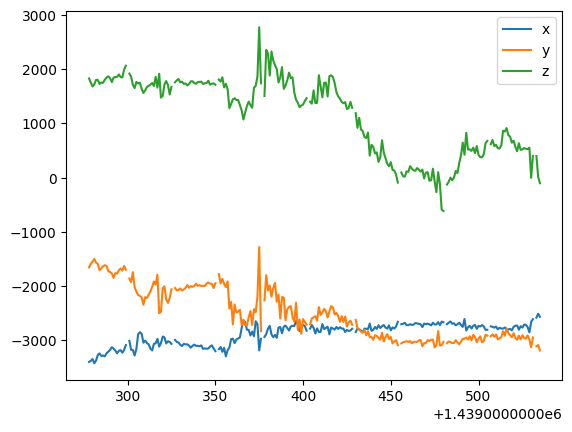

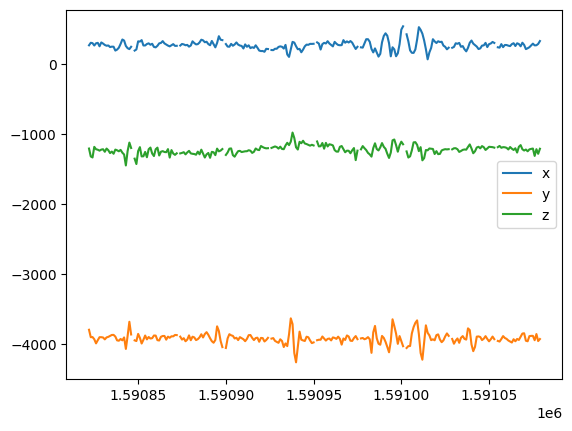

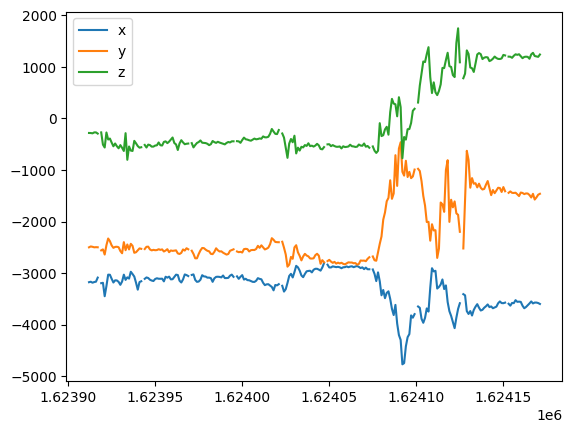

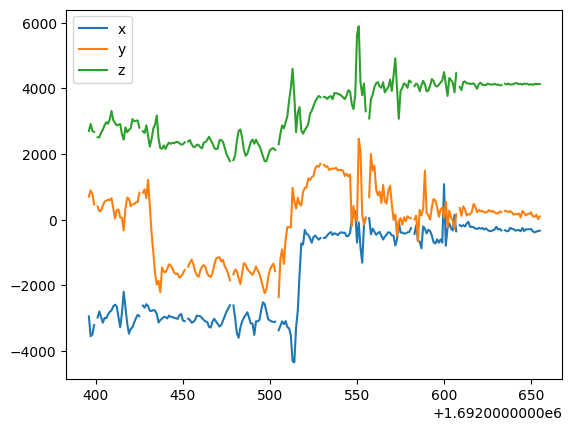

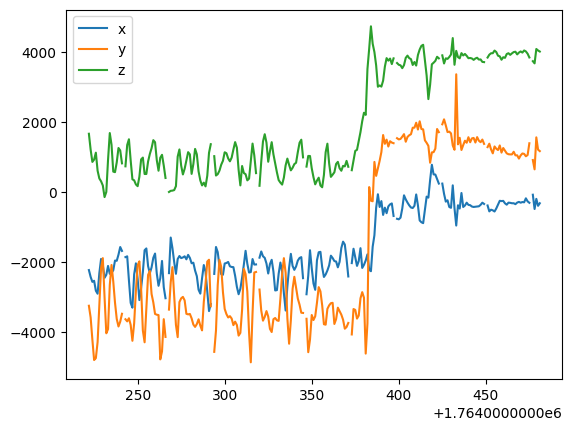

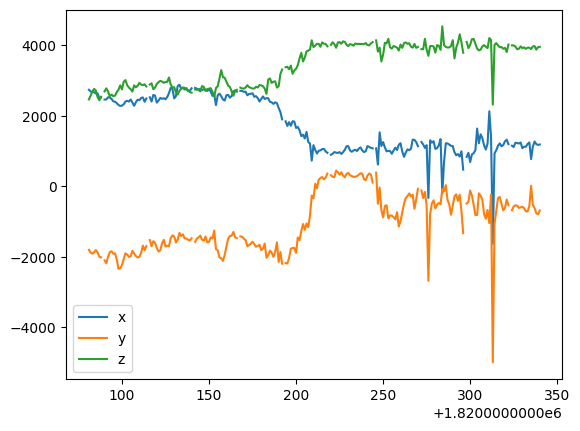

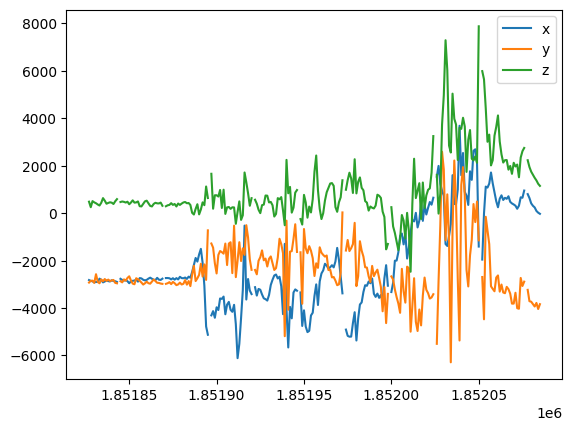

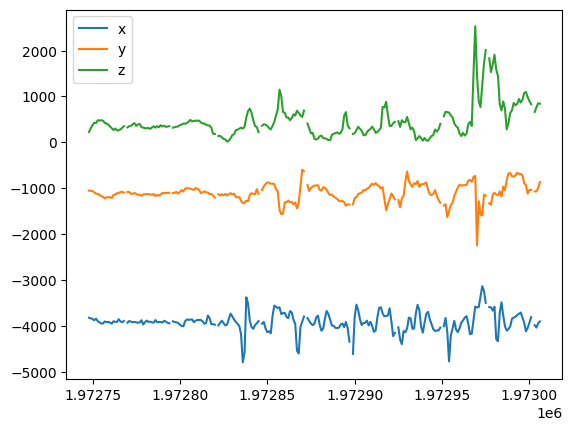

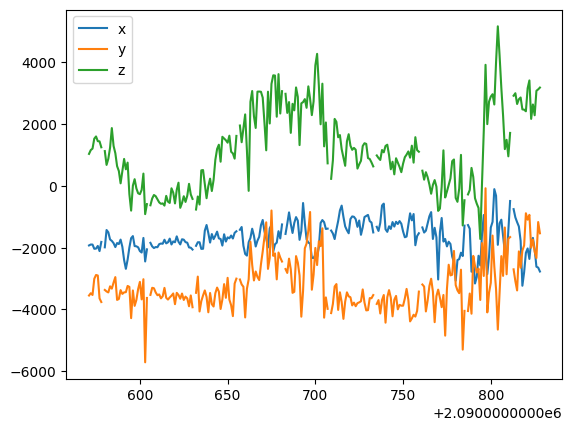

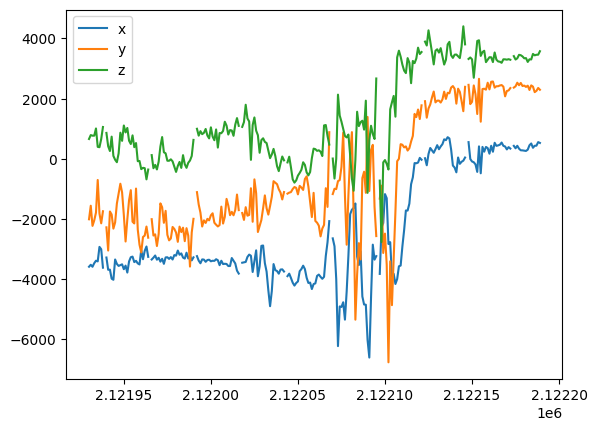

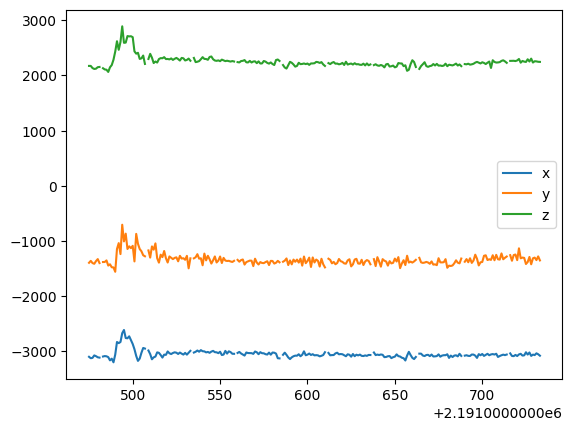

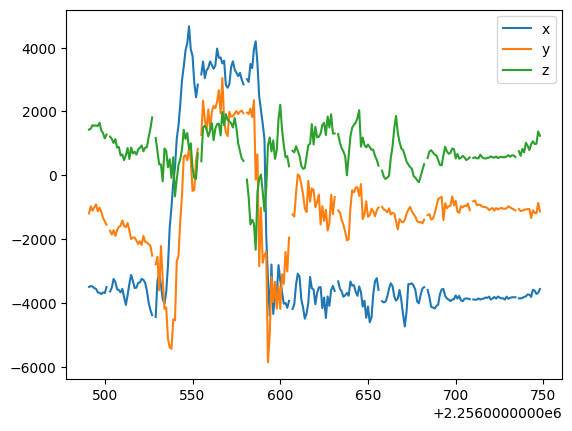

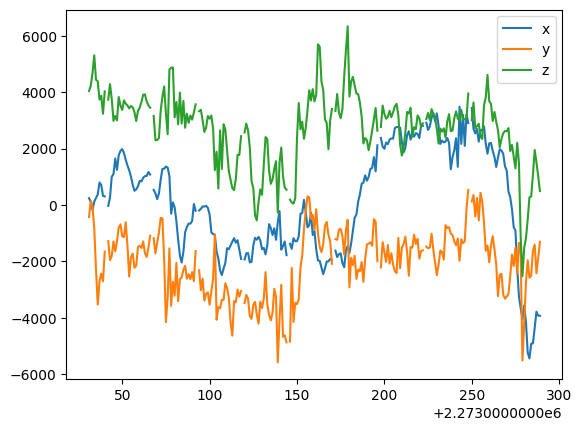

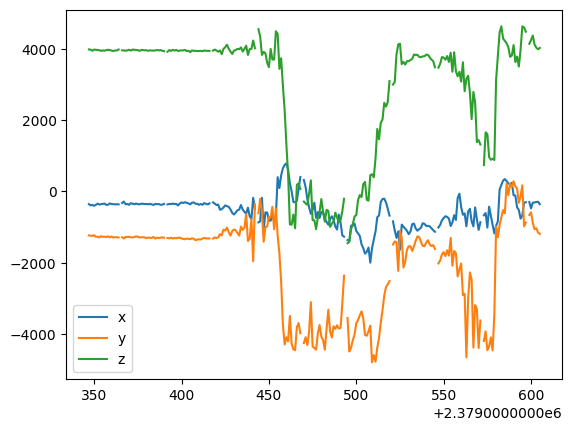

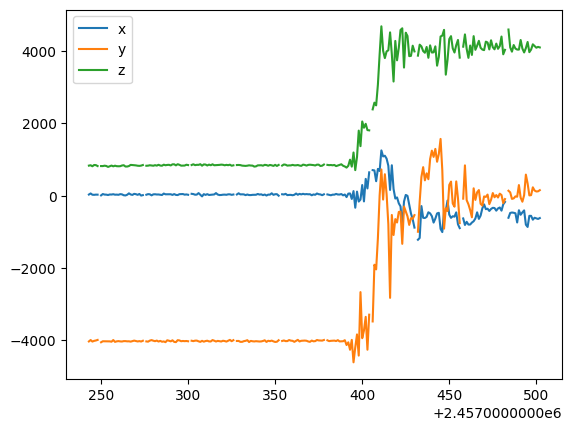

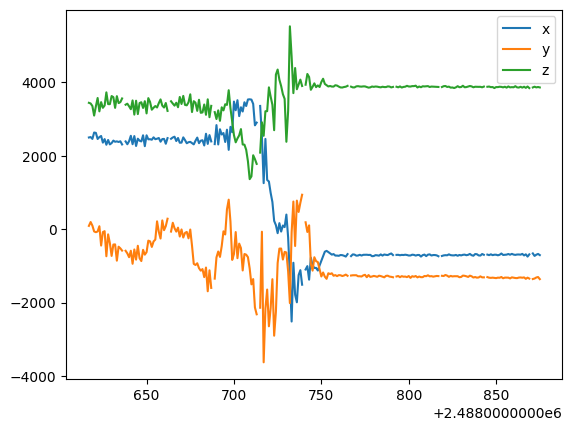

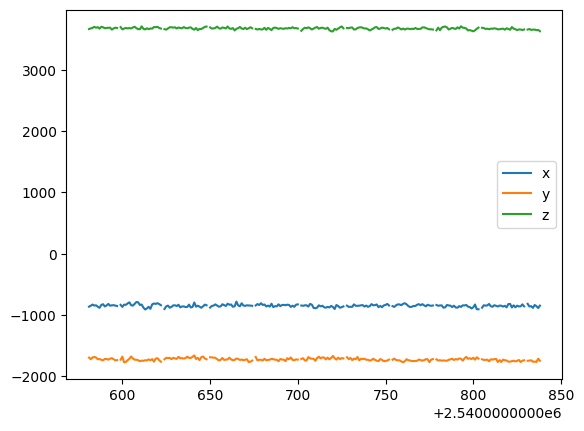

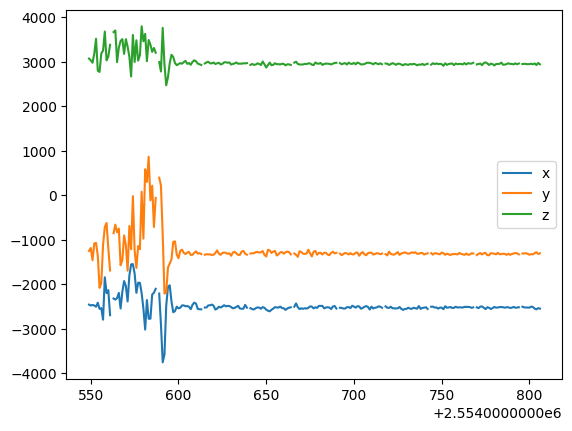

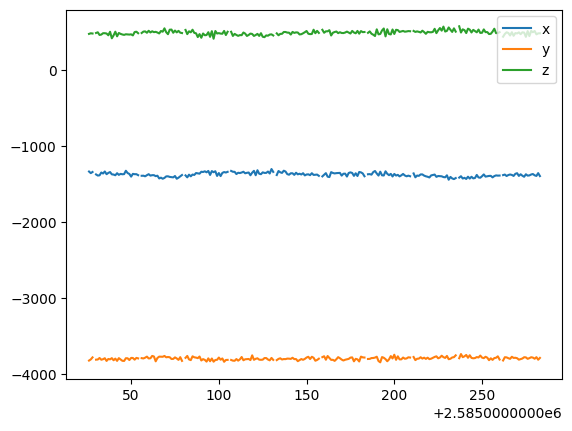

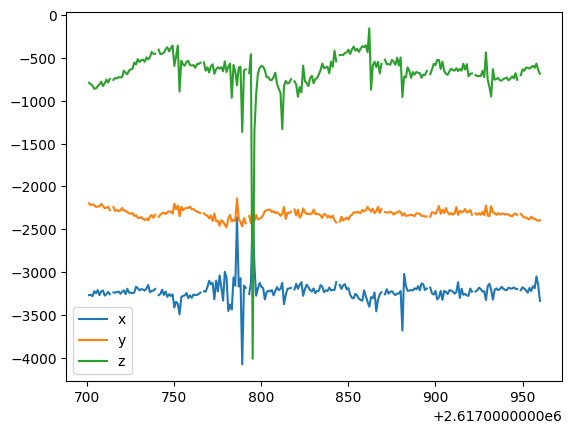

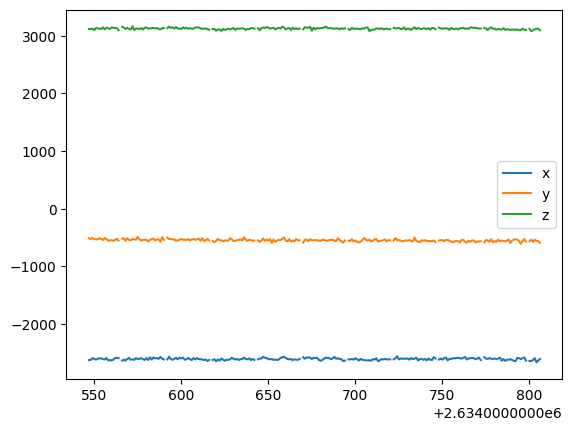

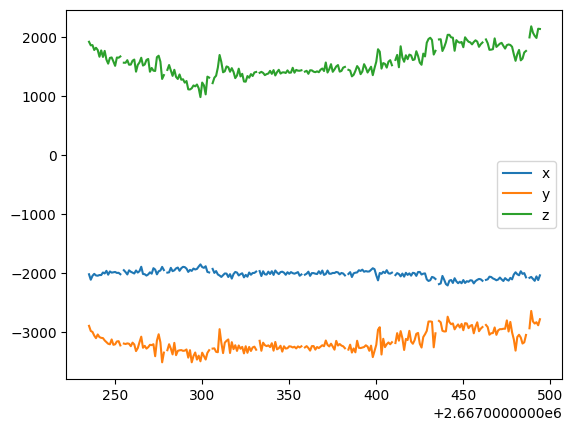

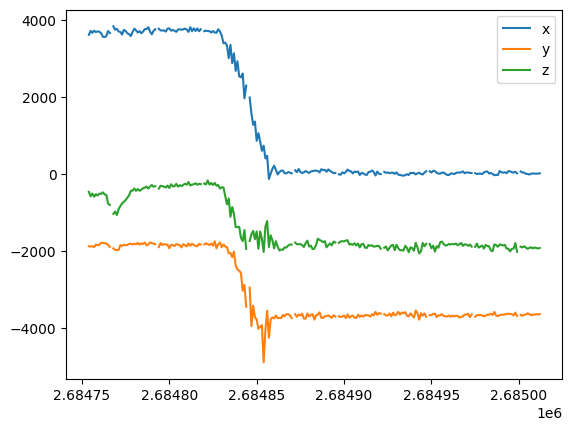

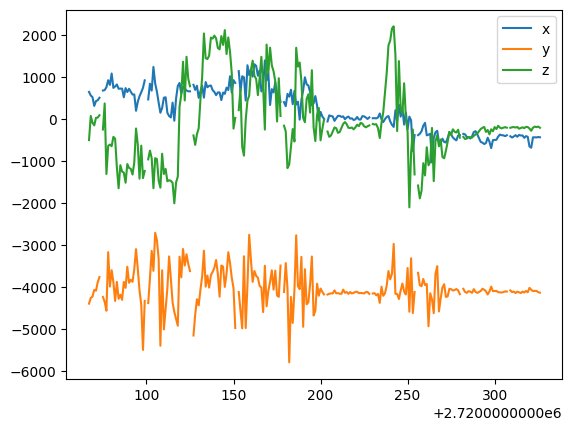

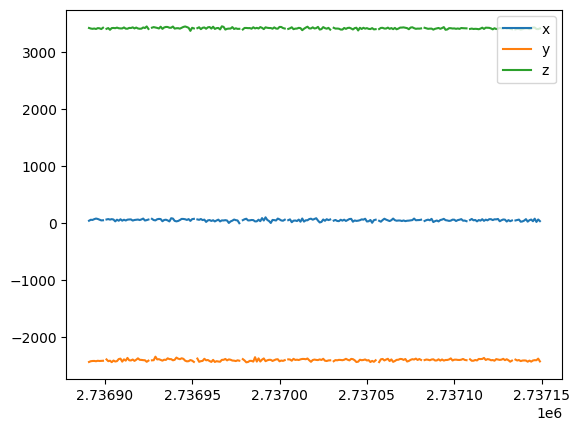

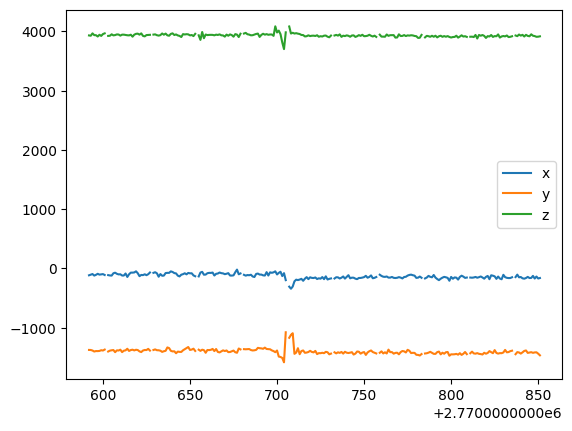

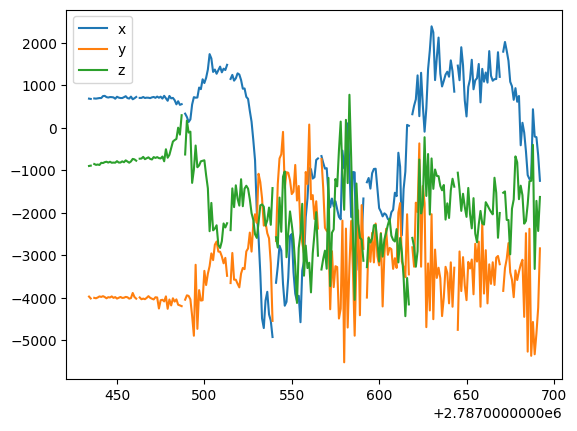

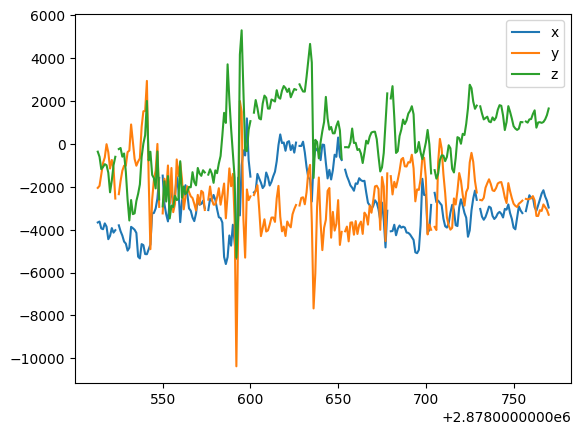

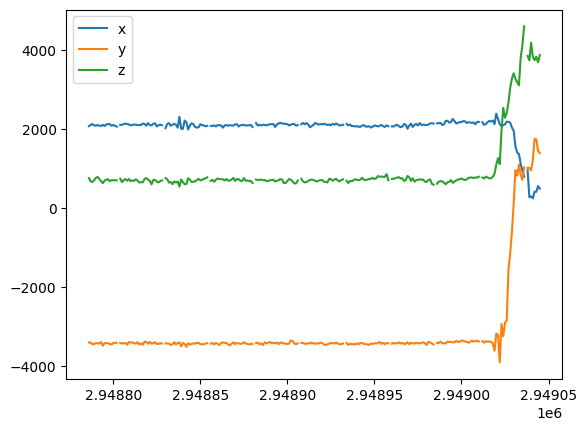

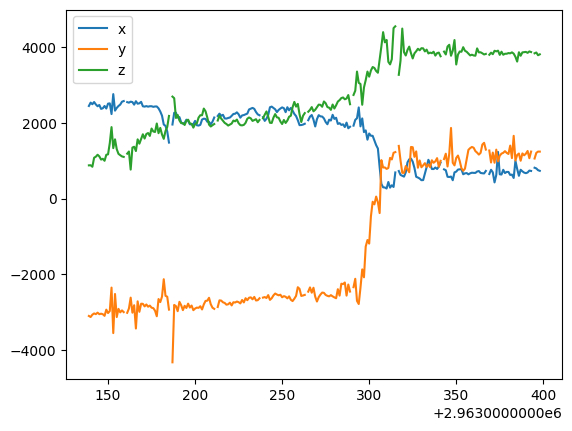

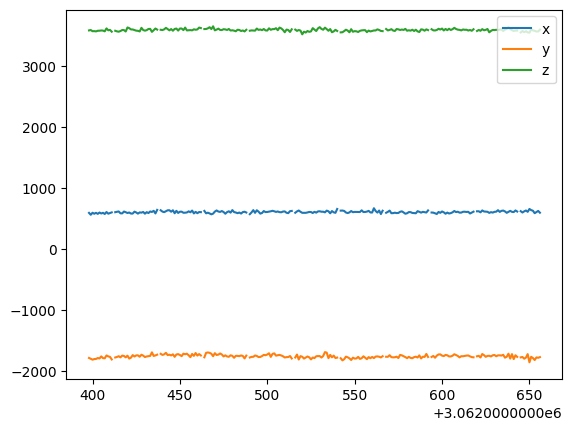

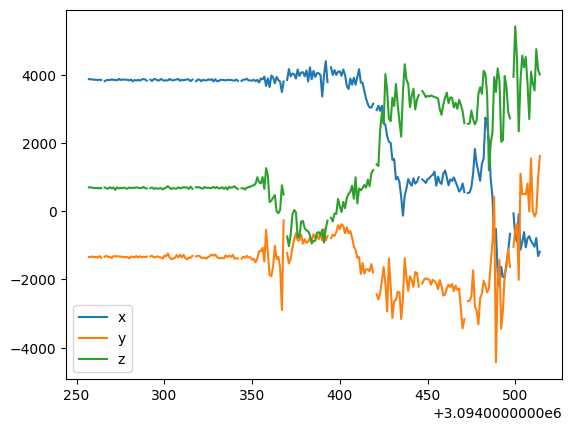

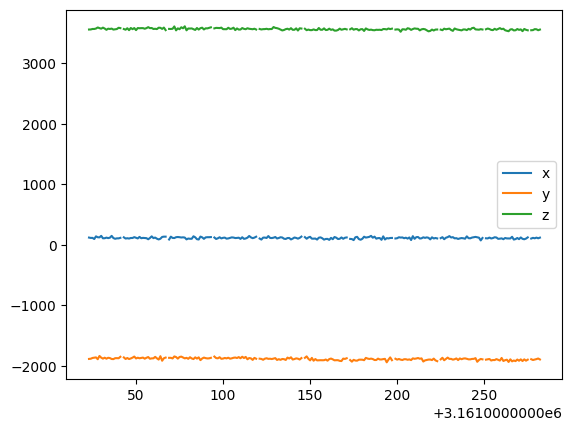

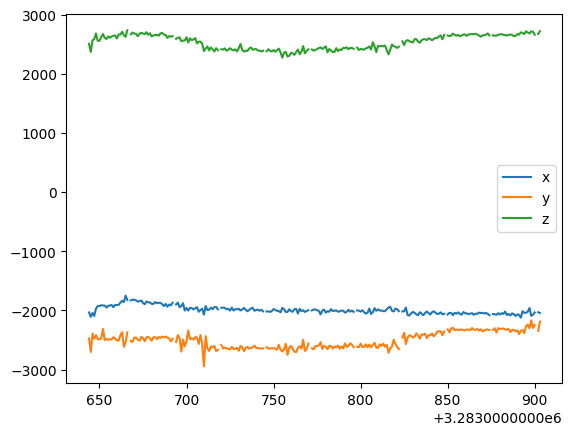

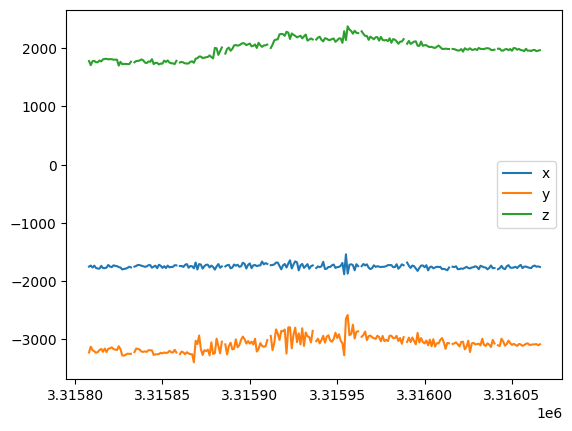

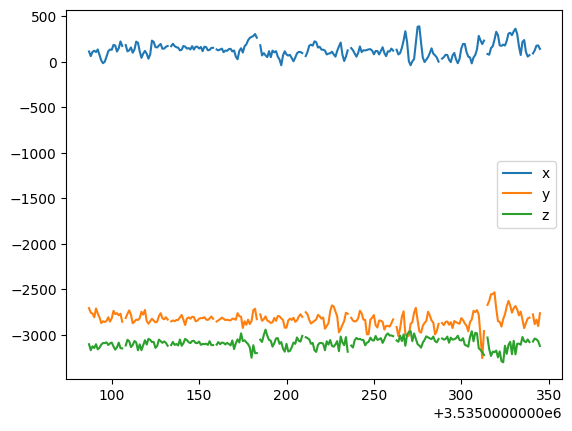

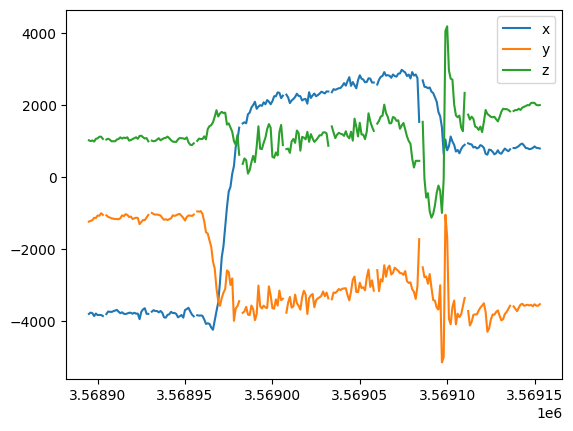

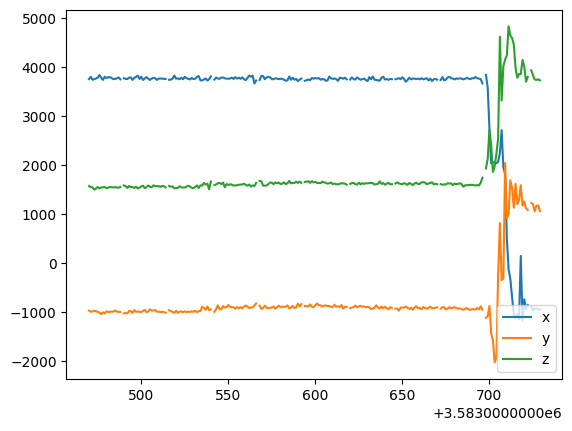

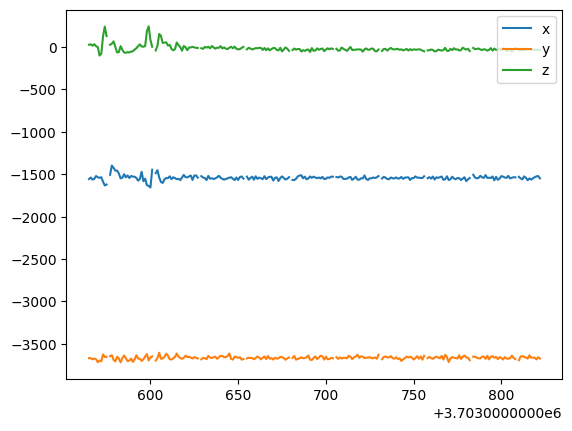

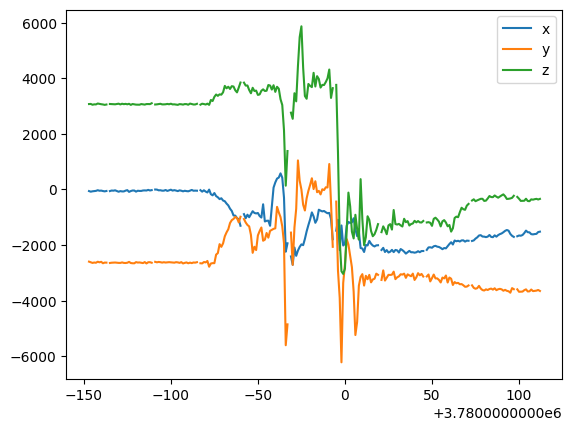

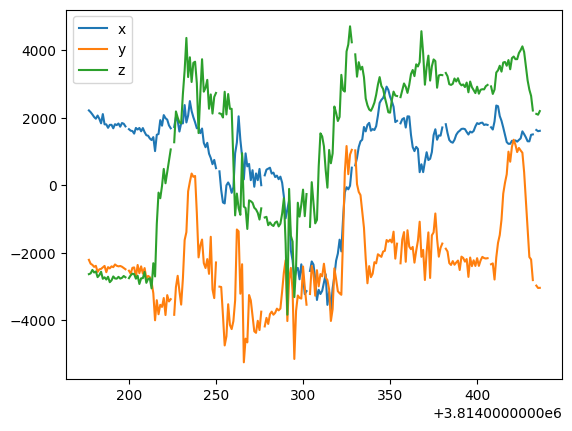

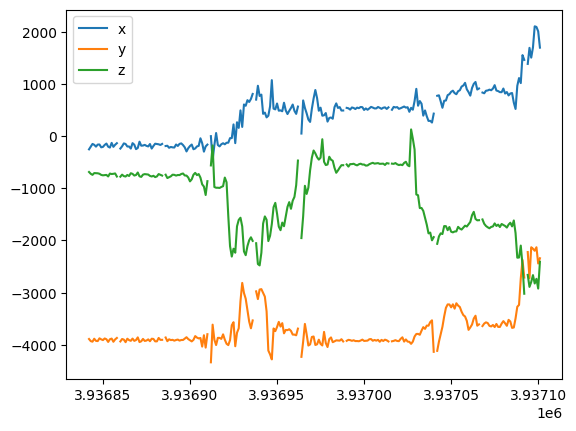

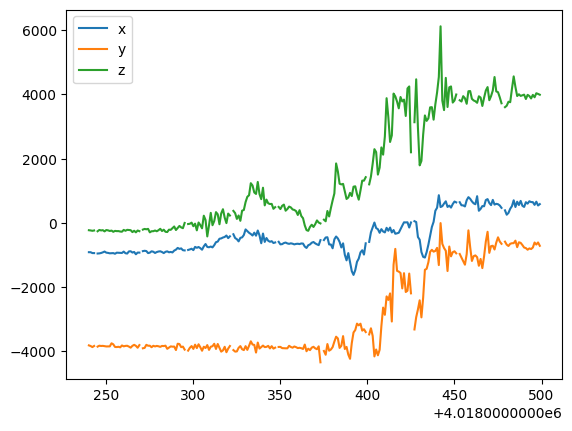

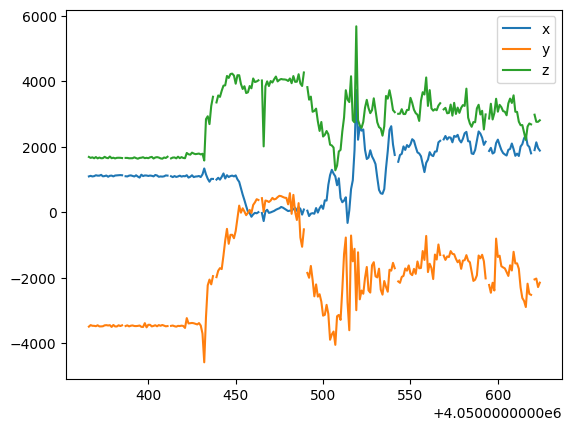

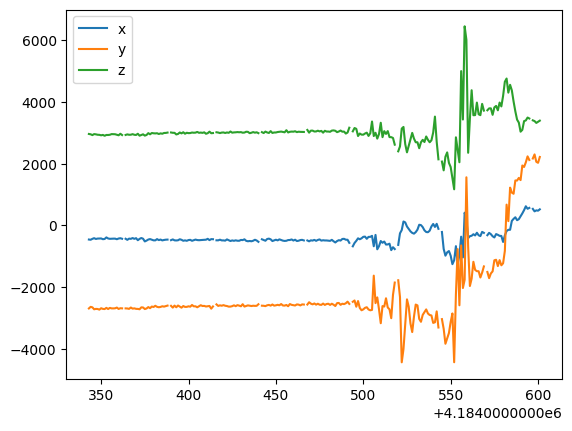

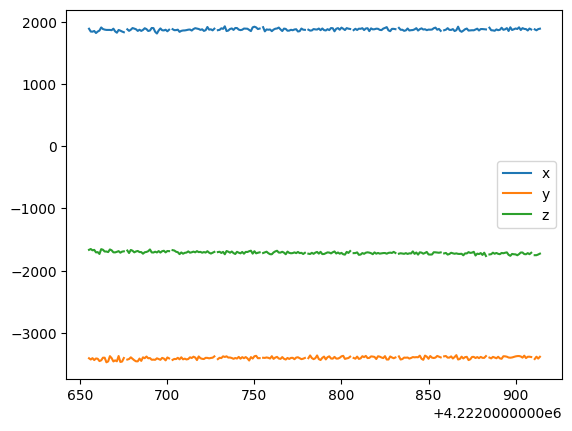

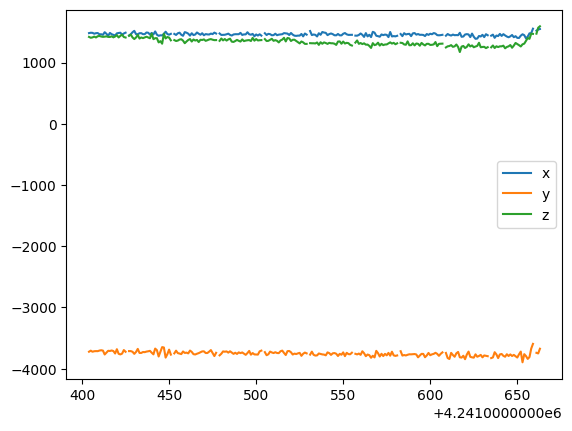

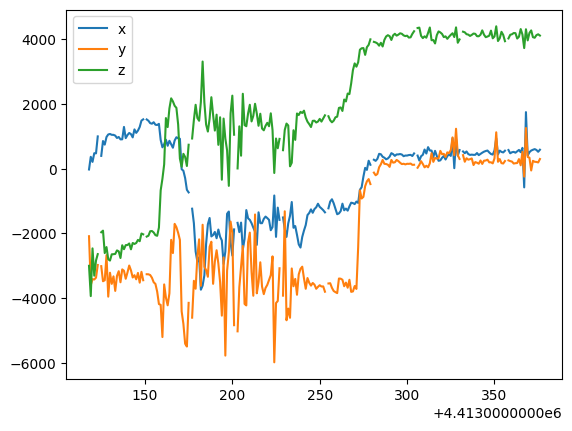

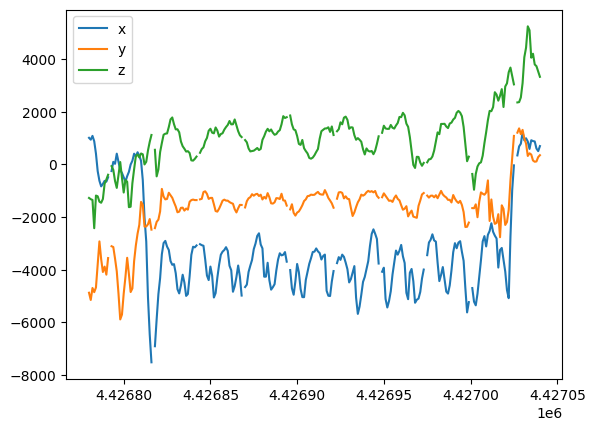

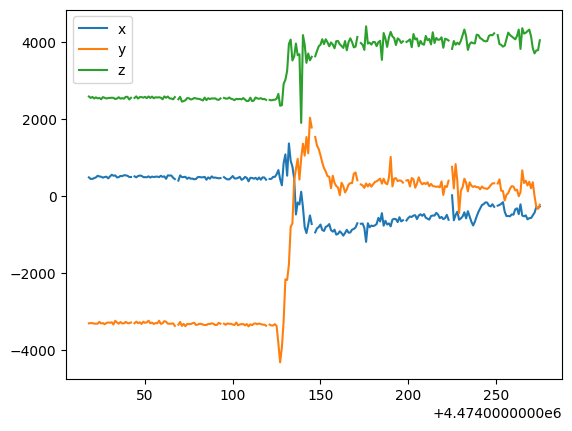

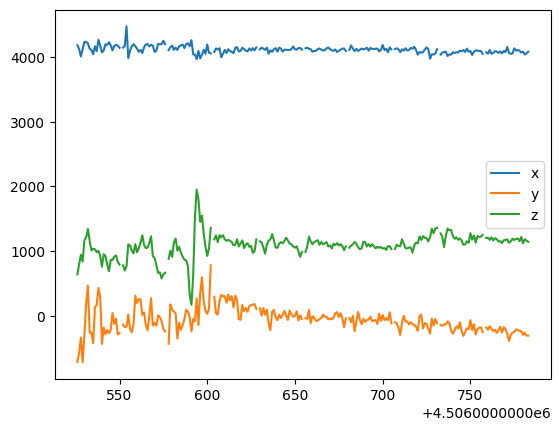

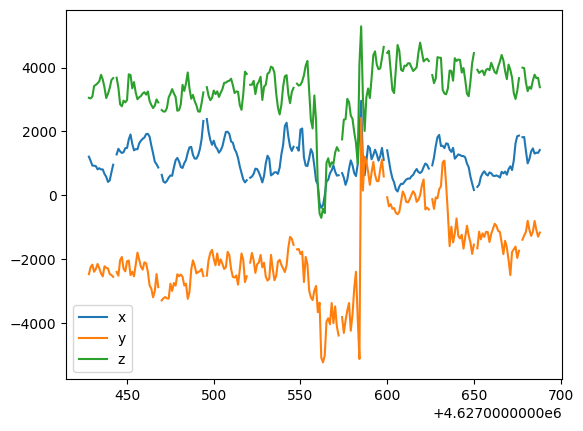

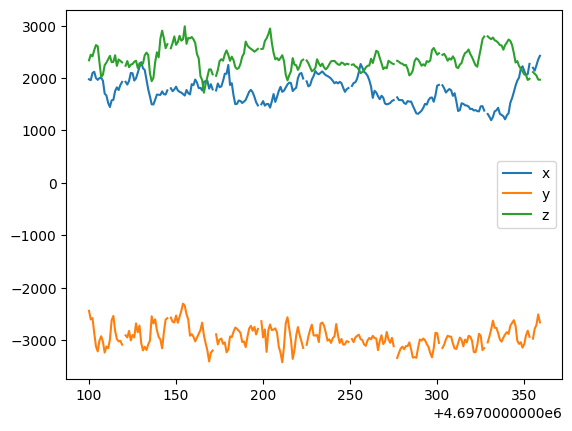

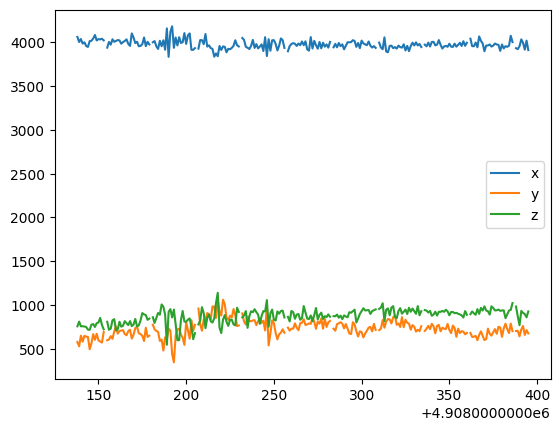

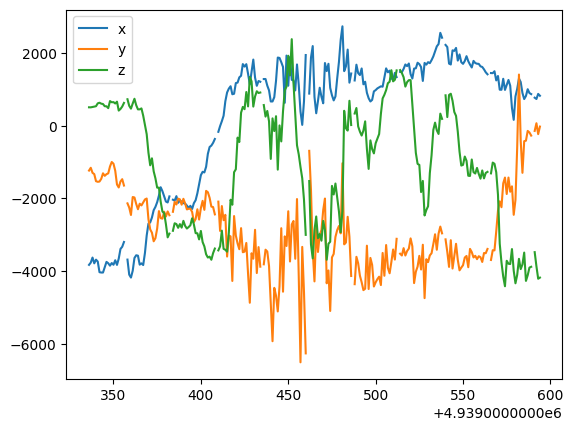

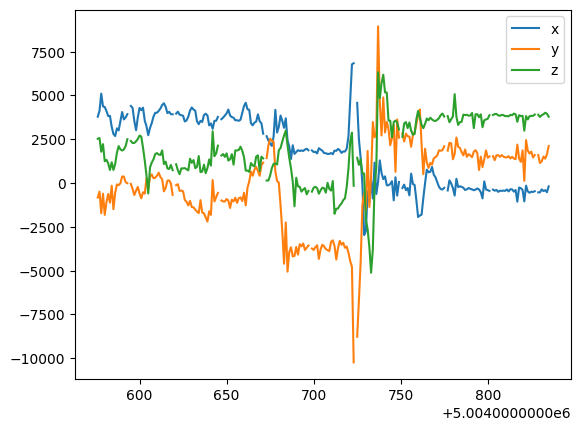

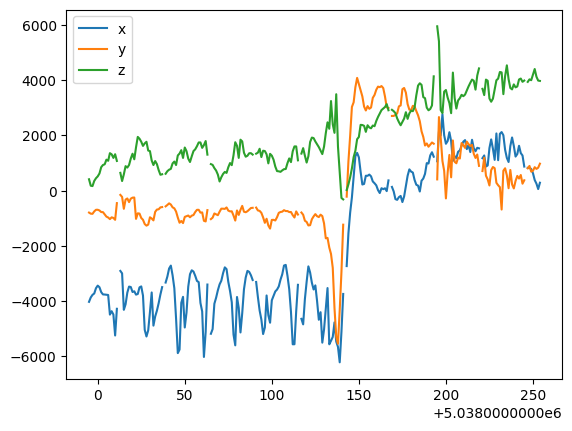

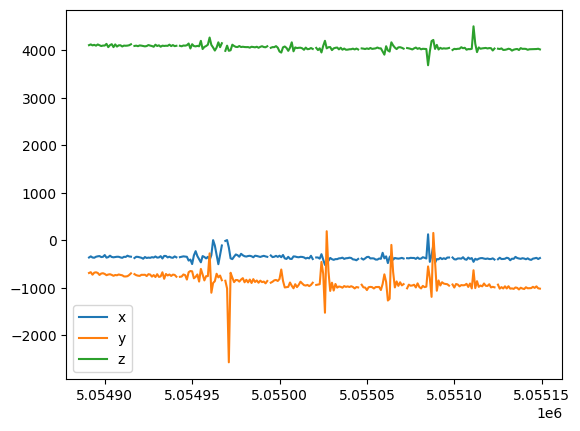

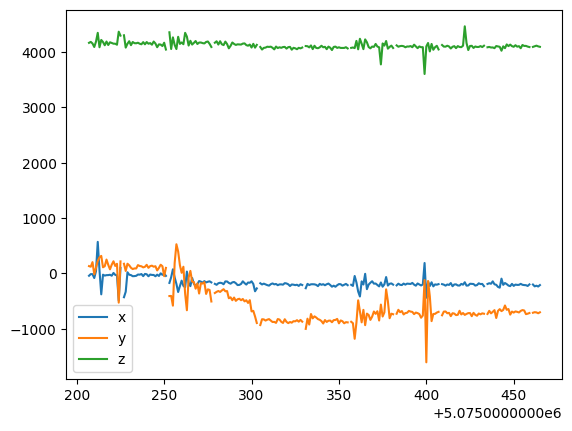

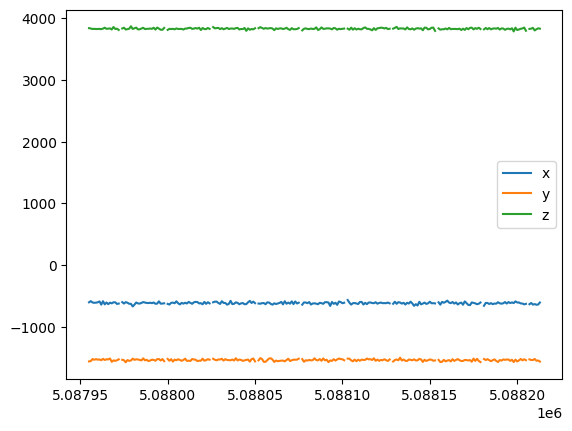

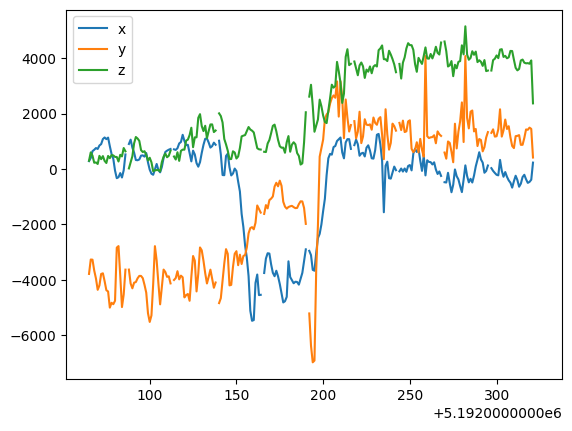

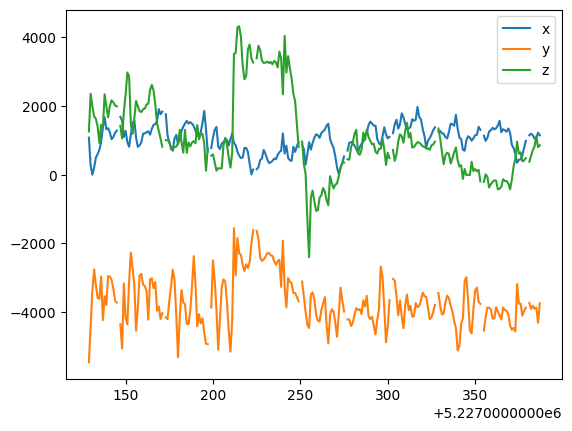

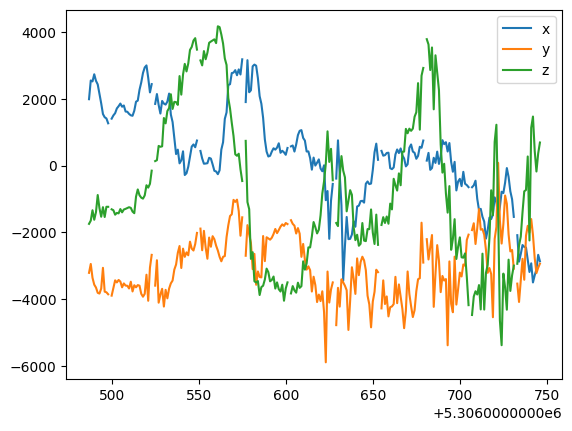

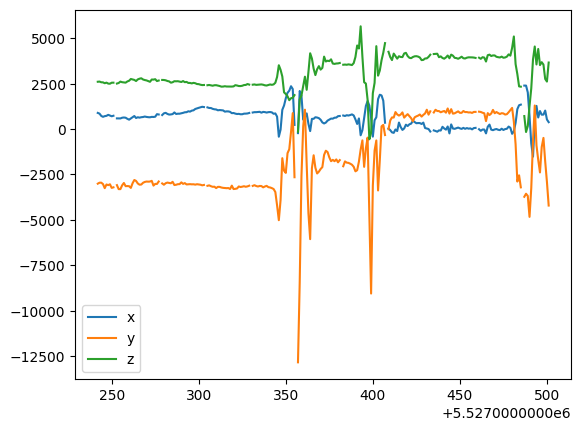

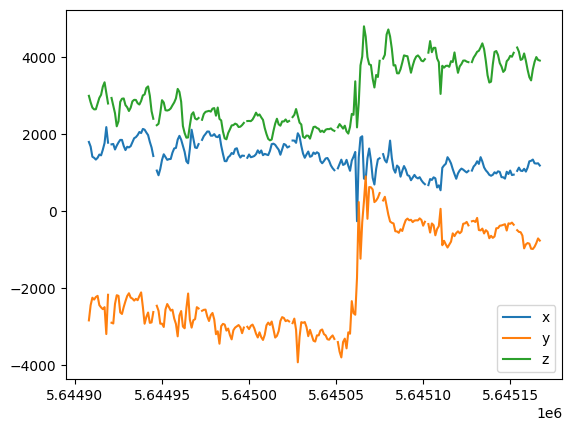

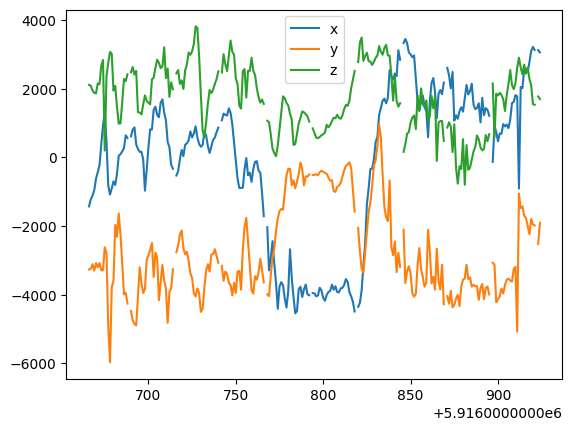

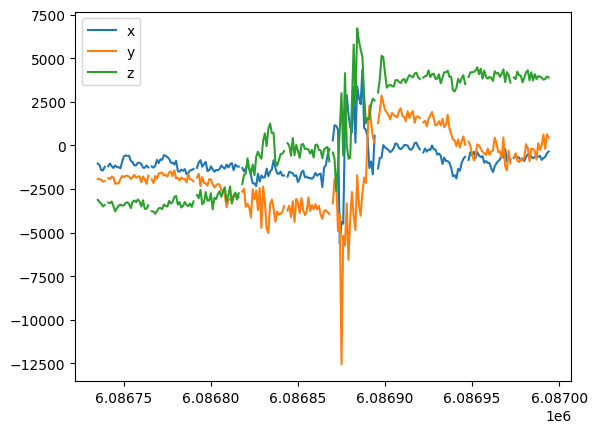

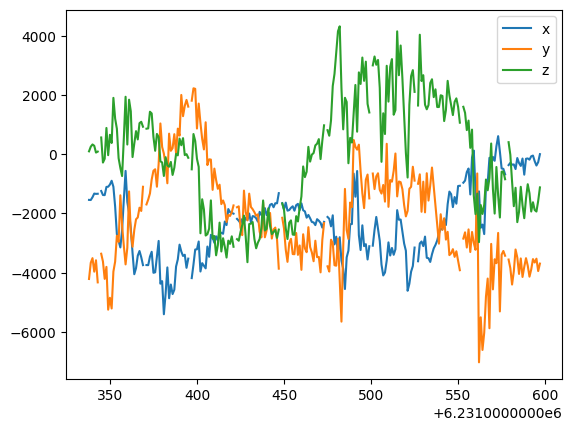

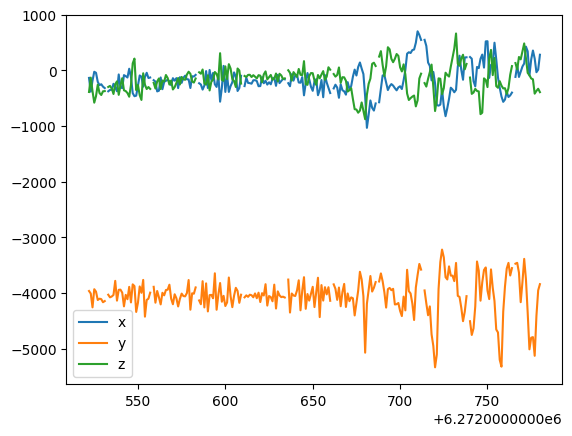

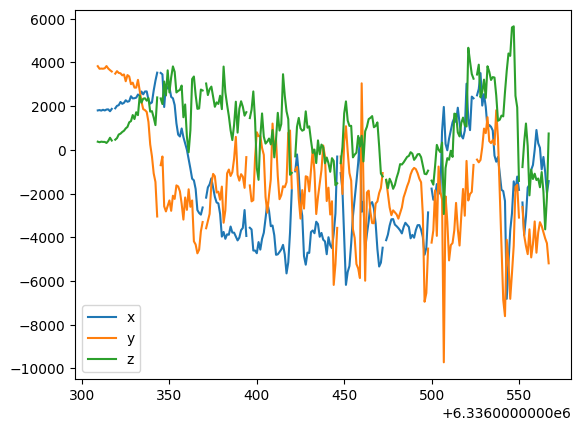

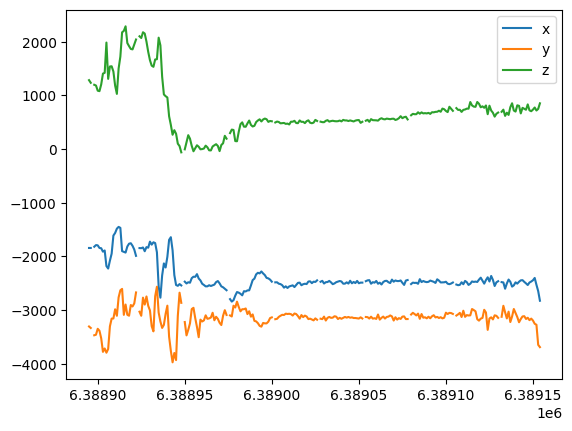

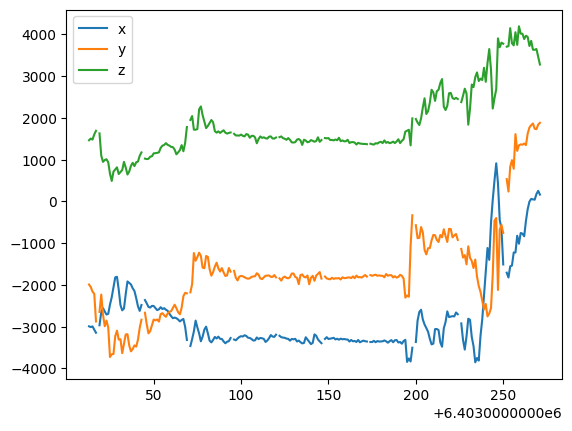

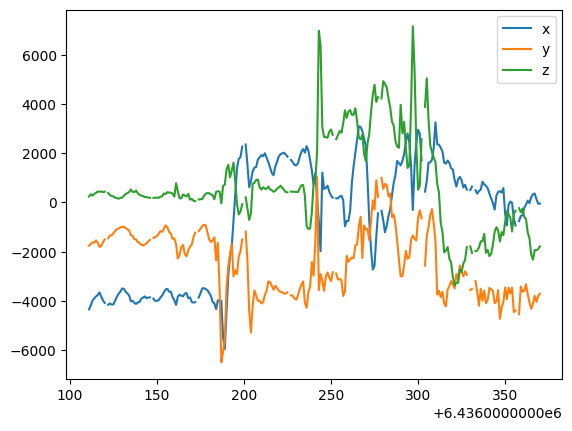

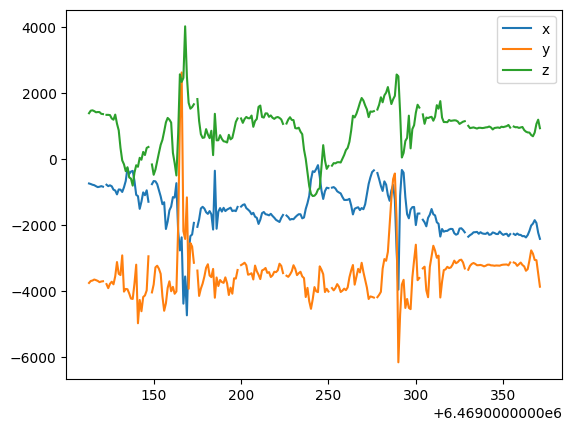

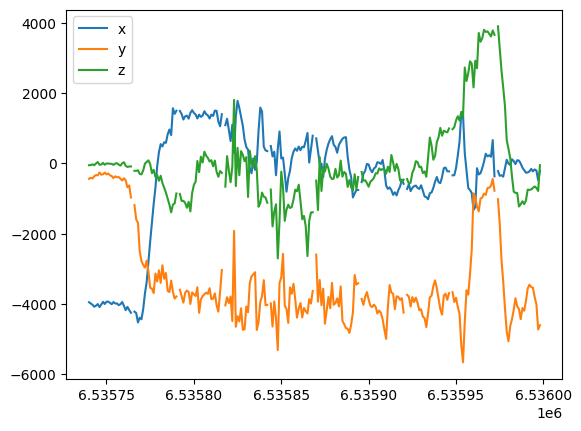

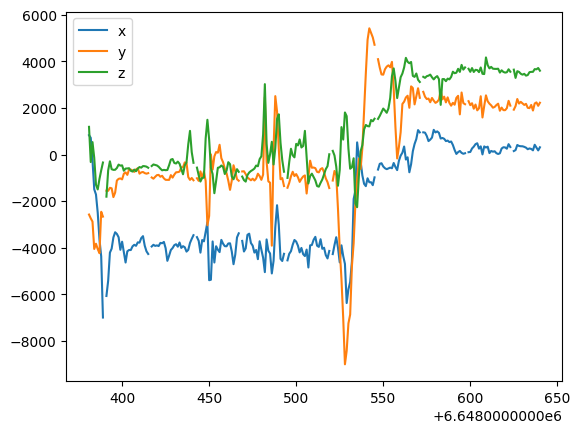

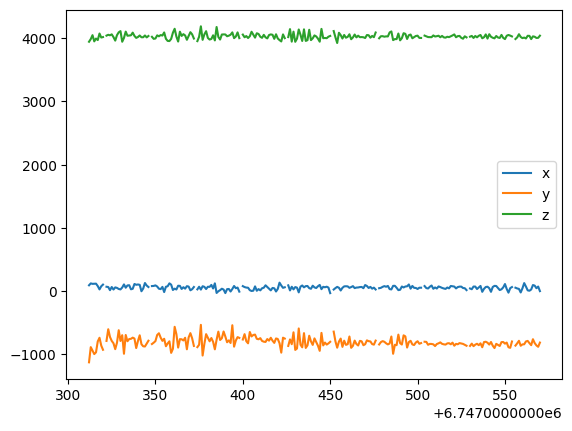

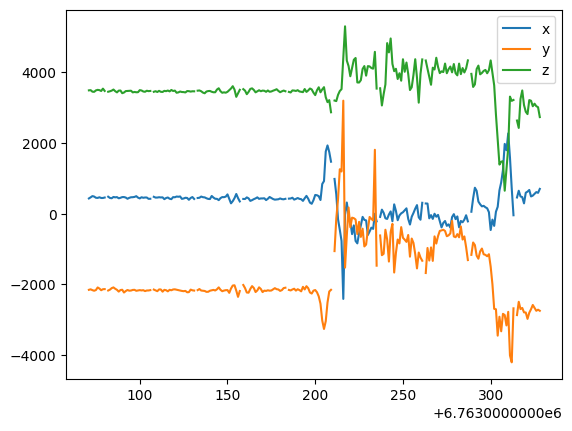

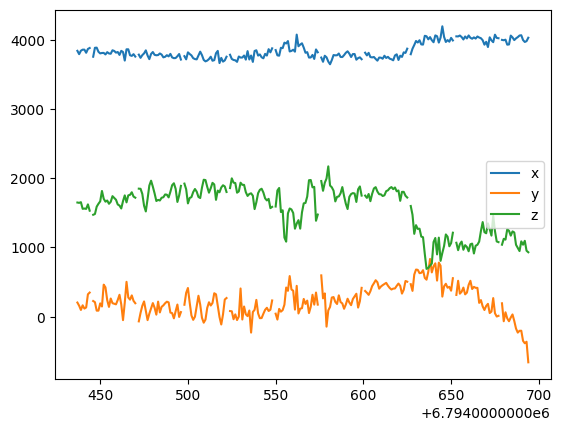

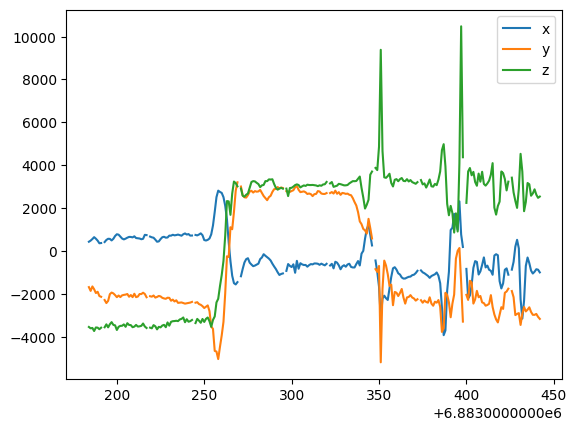

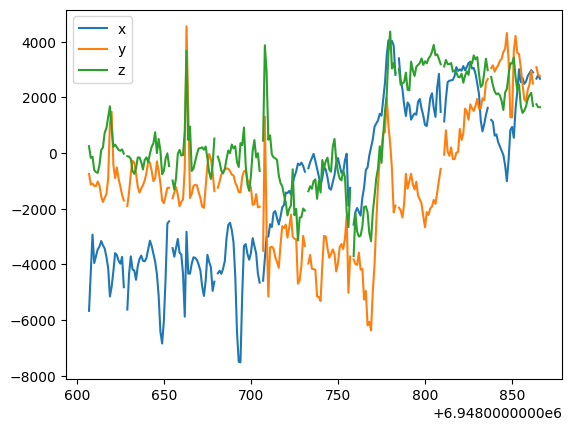

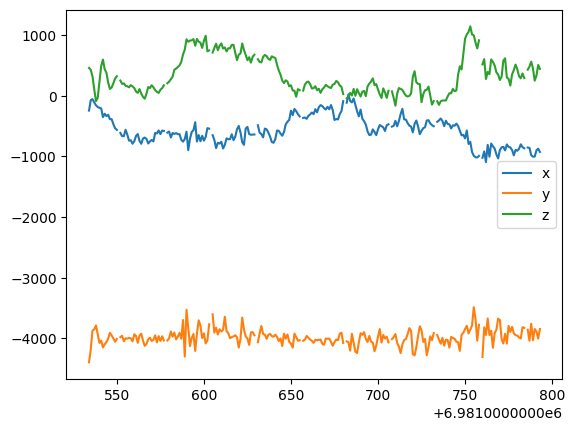

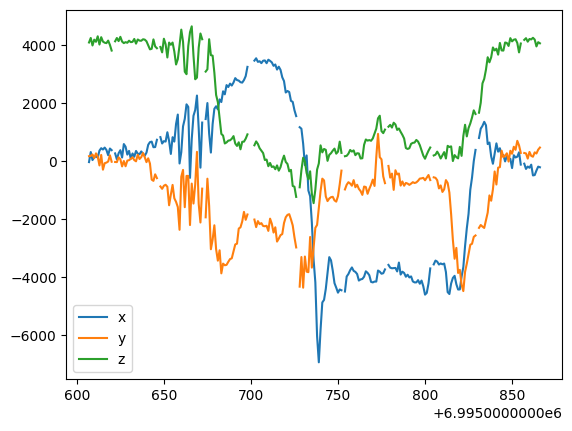

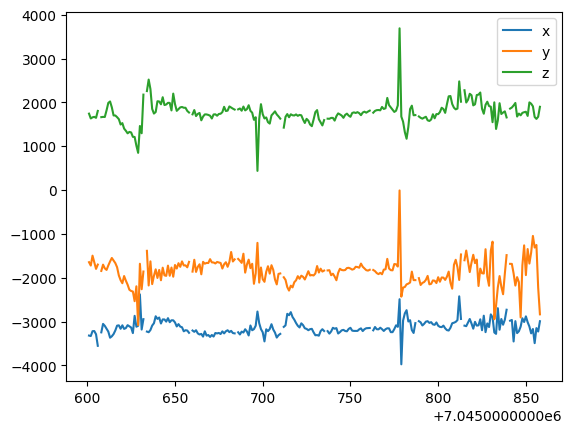

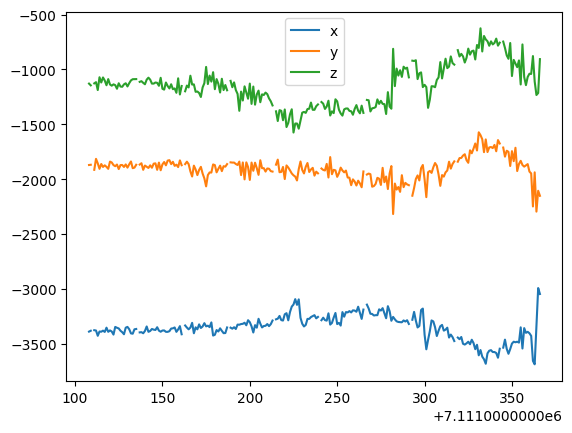

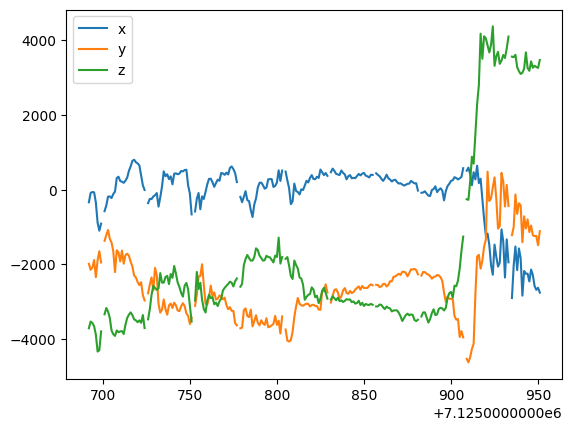

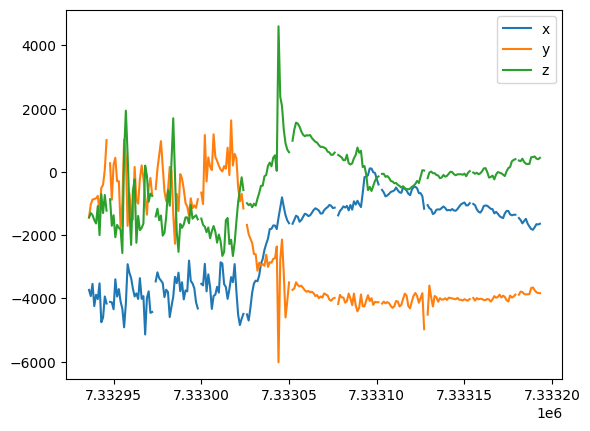

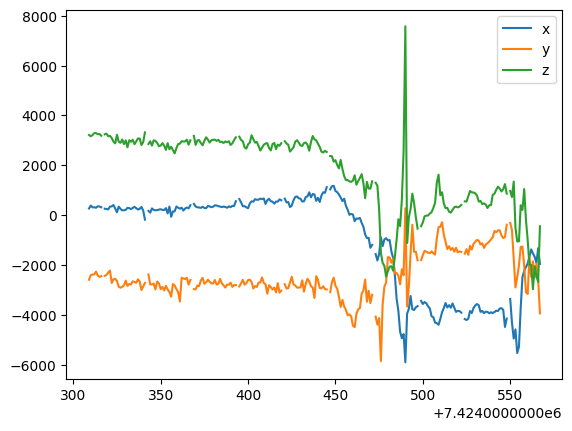

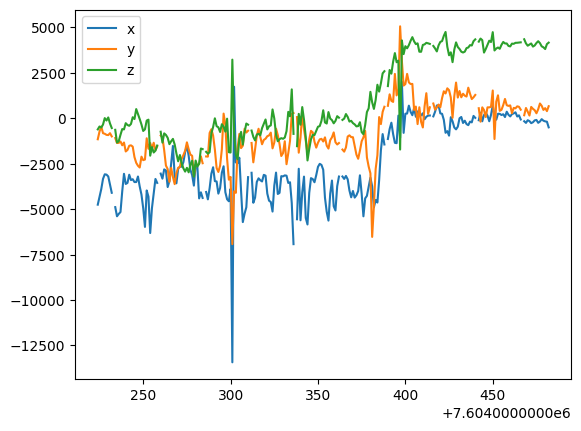

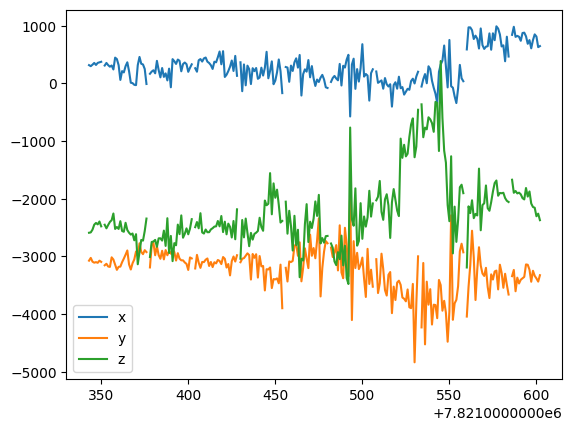

In [14]:
df[df["label"]=="RELAXED"].groupby("label_id")[["x","y","z"]].plot()

In [166]:
df.head()

sessionId  timestamp       x       y       z    hr   hrIbi  label_id  \
0          1     481283   978.0  1674.0  3632.0  99.0  1003.0         1   
1          1     481323   943.0  1717.0  3660.0  99.0  1003.0         1   
2          1     481363  1018.0  1610.0  3818.0  99.0  1003.0         1   
3          1     481403   898.0  1538.0  3733.0  99.0  1003.0         1   
4          1     481444  1028.0  1579.0  3852.0  99.0  1003.0         1   

   label watchId    age  gender  fairNumber  
0      3    0Q3V  18-25  female           1  
1      3    0Q3V  18-25  female           1  
2      3    0Q3V  18-25  female           1  
3      3    0Q3V  18-25  female           1  
4      3    0Q3V  18-25  female           1

In [167]:
df = df[df["label_id"]!=233] #this label does not have hr data, skipping it for now
df["x_normalized"] = df.groupby('watchId')['x'].apply(normalizer)
df["y_normalized"] = df.groupby('watchId')['y'].apply(normalizer)
df["z_normalized"] = df.groupby('watchId')['z'].apply(normalizer)
df["hrIbi_normalized"] = df.groupby('watchId')['hrIbi'].apply(normalizer)


In [168]:
grouped = df.groupby("label_id")
min = len(grouped.get_group(1))
for i in range(len(grouped)-1):
    if len(grouped.get_group(i+2))<min:
        min = len(grouped.get_group(i+2))

X = []
Y = []
for i in range(len(grouped)):
    X.append(grouped.get_group(i+1)[["x", "y", "z", "hrIbi", "hr"]][:min])
    # X.append(grouped.get_group(i+1)[["x_normalized", "y_normalized", "z_normalized", "hrIbi_normalized"]][:min])
    Y.append(grouped.get_group(i+1).iloc[0][["label"]])

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(232, 258, 5)
(232, 1)


In [193]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(185, 258, 5)
(185, 1)
(47, 258, 5)
(47, 1)


In [194]:
Y_train = np.array(Y_train).astype('float32')
X_train = np.array(X_train).astype('float32')
Y_test = np.array(Y_test).astype('float32')

In [195]:
X_train.shape

(185, 258, 5)

In [196]:
model = Sequential()
model.add(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
# model.add(Dense(256, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 258, 64)           17920     
                                                                 
 lstm_35 (LSTM)              (None, 64)                33024     
                                                                 
 dense_43 (Dense)            (None, 16)                1040      
                                                                 
 dense_44 (Dense)            (None, 4)                 68        
                                                                 
Total params: 52052 (203.33 KB)
Trainable params: 52052 (203.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [197]:
adam_optimizer = keras.optimizers.AdamW(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [200]:
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
6/6 [==============================] - 2s 237ms/step - loss: 1.1547 - accuracy: 0.5482 - val_loss: 1.4952 - val_accuracy: 0.1579
Epoch 2/10
6/6 [==============================] - 1s 261ms/step - loss: 1.1174 - accuracy: 0.6084 - val_loss: 1.4988 - val_accuracy: 0.1579
Epoch 3/10
6/6 [==============================] - 1s 216ms/step - loss: 1.1078 - accuracy: 0.5904 - val_loss: 1.5086 - val_accuracy: 0.1579
Epoch 4/10
6/6 [==============================] - 1s 218ms/step - loss: 1.0815 - accuracy: 0.5843 - val_loss: 1.5617 - val_accuracy: 0.1579
Epoch 5/10
6/6 [==============================] - 1s 206ms/step - loss: 1.1109 - accuracy: 0.5301 - val_loss: 1.5180 - val_accuracy: 0.2105
Epoch 6/10
6/6 [==============================] - 1s 235ms/step - loss: 1.0960 - accuracy: 0.5663 - val_loss: 1.5379 - val_accuracy: 0.2105
Epoch 7/10
6/6 [==============================] - 1s 213ms/step - loss: 1.0522 - accuracy: 0.6325 - val_loss: 1.5702 - val_accuracy: 0.1053
Epoch 8/10
6/6 [====

In [201]:
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

# You can also print a classification report for more detailed evaluation metrics
print(classification_report(Y_test, Y_pred))

2/2 [==============================] - 0s 71ms/step
Accuracy: 0.425531914893617
              precision    recall  f1-score   support

         0.0       0.45      0.76      0.57        17
         1.0       0.47      0.54      0.50        13
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00        10

    accuracy                           0.43        47
   macro avg       0.23      0.33      0.27        47
weighted avg       0.29      0.43      0.34        47



In [194]:
single_label = grouped.get_group(100)

In [195]:
single_label = single_label[["timestamp", "x_normalized", "y_normalized", "z_normalized"]]

In [196]:
single_label["timestamp"] = single_label["timestamp"] - single_label.iloc[0]["timestamp"]

In [88]:
timestamps_ms = np.array(single_label.timestamp)  # Replace [...] with your actual timestamps in milliseconds

# Calculate the time difference between consecutive timestamps
time_diff_ms = np.diff(timestamps_ms)

# Calculate the average time difference to get the sampling interval in milliseconds
sampling_interval_ms = np.mean(time_diff_ms)

# Convert the sampling interval to seconds to get the sampling rate (in Hz)
sampling_rate_hz = 1000 / sampling_interval_ms

print("Sampling rate:", sampling_rate_hz, "Hz")

Sampling rate: 26.023421078971076 Hz


In [94]:
sampling_interval_ms/1000

0.038426923076923074

In [18]:
one_sample=  df.groupby("label_id").get_group(23).x

In [24]:
def add_gaussian_noise(time_series, mean=0.0, stddev=1.0):
    """
    Adds Gaussian noise to a time series.

     Options:
     time_series (array-like): A time series to which noise is added.
     mean (float): The average value of the noise. Default is 0.0.
     stddev (float): Standard deviation of noise. Default is 1.0.

     Returns:
     noisy_series (np.array): Time series with added noise.
     """
     # Gaussian noise generation
    noise = np.random.normal(mean, stddev, len(time_series))

    # Adding noise to the original time series
    noisy_series = time_series + time_series* noise

    return noisy_series

augmented_time_series_data = add_gaussian_noise(one_sample, mean=0.0, stddev=0.05)

<AxesSubplot:>

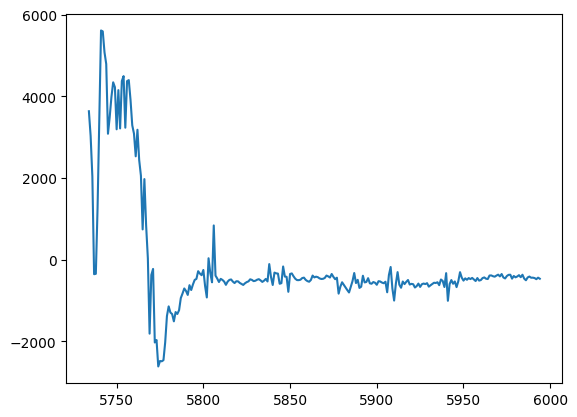

In [25]:
augmented_time_series_data.plot()

<AxesSubplot:>

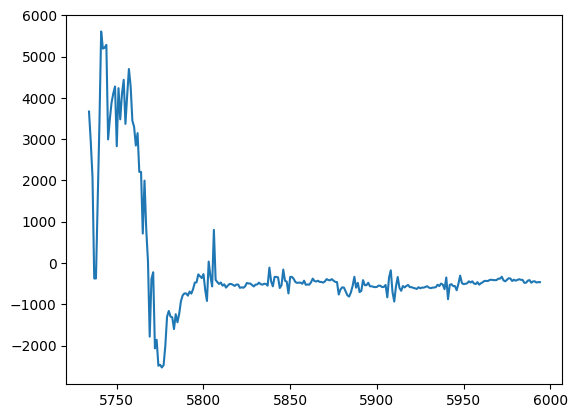

In [27]:
one_sample.plot()

<AxesSubplot:>

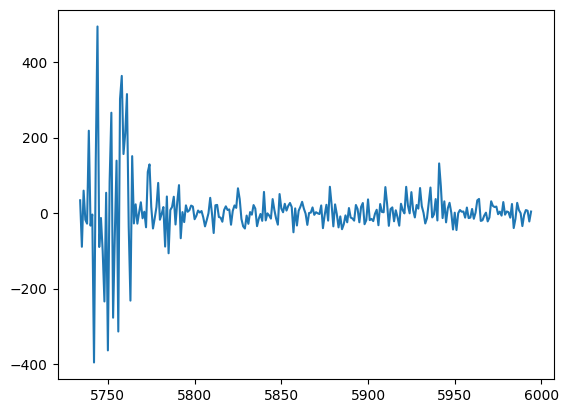

In [26]:
(one_sample-augmented_time_series_data).plot()

In [148]:
#grouped = df.groupby("label_id")
#for i in range(len(grouped)):
#    single_label = grouped.get_group(i+1)
#    f, t, Sxx = signal.spectrogram(np.array(single_label.x), 1/26)
#    print("label", single_label.iloc[0]["label"])
#    plt.pcolormesh(Sxx, shading='flat')
#    plt.show()


In [137]:
len(grouped)

233

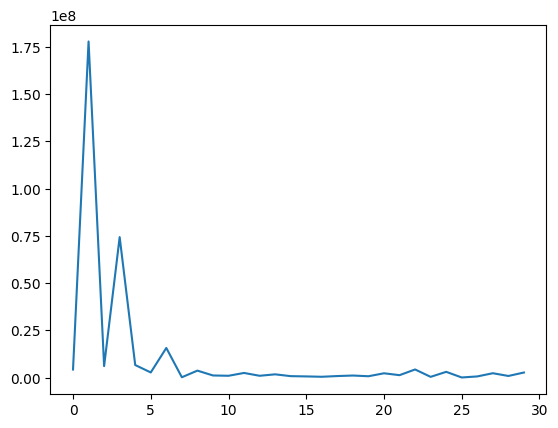

In [133]:
plt.plot(Sxx[:30])

In [46]:
# define two sets of inputs
inputA = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
inputB = keras.Input(shape=(4,))
# the first branch operates on the first input
x = LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)(inputA)
x = LSTM(64)(x)
x = Dense(8, activation="relu")(x)
x = Dense(4, activation="relu")(x)
x = keras.Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(32, activation="relu")(inputB)
y = Dense(4, activation="relu")(y)
y = keras.Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = keras.layers.concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = keras.Model(inputs=[x.input, y.input], outputs=z)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 258, 4)]             0         []                            
                                                                                                  
 lstm_6 (LSTM)               (None, 258, 64)              17664     ['input_1[0][0]']             
                                                                                                  
 lstm_7 (LSTM)               (None, 64)                   33024     ['lstm_6[0][0]']              
                                                                                                  
 input_2 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                            

In [ ]:
#max_hr, min_hr, fair_number hrIbi

In [61]:
df.groupby(["label"])["hr"].min()+df.groupby(["label"])["hr"].max()-df.groupby(["label"])["hr"].mean()

label
0     92.703167
1    100.304933
2     78.774983
3     99.741603
Name: hr, dtype: float64

In [62]:
df.groupby(["label"])["hr"].max()

label
0    112.0
1    121.0
2    106.0
3    120.0
Name: hr, dtype: float64

In [75]:
df.groupby(["label_id"])["hrIbi"].std()

label_id
1        0.000000
2        0.000000
3       64.751707
4      198.418151
5      146.977869
          ...    
228    769.089874
229    778.051254
230    676.365471
231    439.637798
232      0.000000
Name: hrIbi, Length: 232, dtype: float64

In [106]:
sns.swarmplot(df[["hrIbi",  "label", "label_id", "gender"]].groupby("label_id").median(), x="hrIbi", y="label", hue="gender")

ValueError: Could not interpret value `gender` for `hue`. An entry with this name does not appear in `data`.

In [84]:
df["hr"]

0        99.0
1        99.0
2        99.0
3        99.0
4        99.0
         ... 
60393    92.0
60394    92.0
60395    92.0
60396    92.0
60397    92.0
Name: hr, Length: 60398, dtype: float64

In [96]:
df[["hr", "label", "label_id"]].groupby("label_id").max()

hr  label
label_id              
1          99.0      3
2          78.0      0
3          82.0      1
4         120.0      3
5         121.0      1
...         ...    ...
228        86.0      0
229        80.0      3
230        80.0      0
231        89.0      3
232        92.0      0

[232 rows x 2 columns]